In [1]:
import pylef   # importar pylef 
import visa    # importar a bilioteca pyVISA para lidar com virtualização de instrumentos
import matplotlib.pyplot as plt  # importar a bilioteca pyplot para fazer gráficos
import numpy as np   # importar a biblioteca Numpy para lidar com matrizes
import time          # importar a bilioteca para funções temporais
import pandas as pd   # importa bilioteca pandas para  lidar com processamento de dados
import os

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/visa.py:23: FutureWarning: The visa module provided by PyVISA is being deprecated. You can replace `import visa` by `import pyvisa as visa` to achieve the same effect.

The reason for the deprecation is the possible conflict with the visa package provided by the https://github.com/visa-sdk/visa-python which can result in hard to debug situations.
  FutureWarning,


In [2]:
def screenshot(filename):
    #function to capture screenshots from oscilloscope
    #setting up hardcopy
    scope.instr.timeout = 20000 # set timeout to 10 seconds
    form = 'jpeg'
    strings = ['SAVE:IMAGE:FILEFORMAT '+form,
               'HARDCOPY:BUTTON PRINTS',
              'HARDCopy:PORT']
    for string in strings:
        scope.write(string)
        scope.wait()
    #screen shot
    scope.instr.write('HARDCOPY START')
    values = scope.instr.read_raw() 
    scope.wait()
    newFile = open(filename+'.'+form, 'wb')
    newFileByteArray = bytearray(values)
    newFile.write(newFileByteArray)
    newFile.close()
    return filename+'.'+form+ ' saved!'

Instrumentos conectados

In [3]:
# imprime os recursos para ter certeza que os instrumentos estão conectados
visa.ResourceManager().list_resources()

('USB0::0x0699::0x03B0::C010160::INSTR',
 'USB0::0xF4ED::0xEE3A::388C14117::INSTR',
 'ASRL1::INSTR',
 'ASRL2::INSTR')

In [4]:
func_gen = pylef.BK4052()          # definição do gerador de funções
scope = pylef.TektronixTBS1062()   # definição do osciloscópio

VisaIOError: VI_ERROR_RSRC_BUSY (-1073807246): The resource is valid, but VISA cannot currently access it.

In [5]:
scope.instr.query('HARDCOPY?')

':HARDCOPY:BUTTON PRINTS;FORMAT JPEG;PORT USB;LAYOUT PORTRAIT;INKSAVER ON\n'

In [8]:
screenshot('fft_exemplo_experimental_pa')

'fft_exemplo_experimental_pa.jpeg saved!'

In [9]:
scope.save_channels('fft_exemplo_experimental_pa')  

... file => 2021_04_04/fft_exemplo_experimental_pa_00_34_22 saved !!


(array([-0.01252, -0.01251, -0.0125 , ...,  0.01245,  0.01246,  0.01247]),
 array([ 0.28,  0.16,  0.12, ..., -0.12, -0.26, -0.36]),
 array([-0.34, -0.42, -0.48, ...,  0.08, -0.04, -0.16]))

In [ ]:
(t1, V1) = scope.ch1.read_channel()  # mede o canal 1
(t2, V2) = scope.ch2.read_channel()  # mede o canal 2

In [51]:
##### Pré-aquisição
# mude a onda para uma senóide! O que acontece se usarmos a onda triângular?
func_gen.ch1.set_function('sine')
## ajuste o trigger externo
# func_gen.ch1.sync_on()   # ligar o sync reference ao canal 1
# scope.trigger.set_source('ext')  # ajusta o trigger para externo no osciloscópio
## ajusta média nos canais
scope.set_average_number(4)  # ajusta o número de médias
scope.set_average()    # turn average ON
#scope.set_sample()       # turn average OFF
## parametros de varredura
PATH = 'exemplo-pylef/passa-baixas/'  # pasta onde salvar todos os arquivos
Vpp = 2.0   # Tensão pico-a-pico na saida do gerador
freq0, freq1, Nfreq = 10, 100e3, 30  # frequências inicial, final e número de pontos
## parâmetros inicias do gerador
func_gen.ch1.set_frequency(freq0) 
func_gen.ch1.set_Vpp(Vpp)
func_gen.ch1.set_offset(0.0)
func_gen.ch1.set_phase(0.0)
## tenha certeza que o gerador está ligado e que o canal 1 está na escala certa
func_gen.ch1.turn_on()   # liga o canal 1
scope.set_horizontal_scale((1/freq0)/4.)  # escala horizontal = 1/4 período (2.5 oscilações em tela)
scope.ch1.set_smart_scale()  # rescala o canal 1
scope.ch2.set_smart_scale()  # rescala o canal 2

## Varredura

In [17]:
def screenshot(filename):
    #setting up hardcopy
#     scope.instr.timeout = 20000 # set timeout to 10 seconds
    strings = ['SAVE:IMAGE:FILEFORMAT BMP',
               'HARDCOPY:BUTTON PRINTS',
              'HARDCopy:PORT']
    for string in strings:
        scope.write(string)
        scope.wait()
    #screen shot
    scope.instr.write('HARDCOPY START')
    values = scope.instr.read_raw() 
    scope.wait()
    newFile = open(filename+'.bmp', 'wb')
    newFileByteArray = bytearray(values)
    newFile.write(newFileByteArray)
    newFile.close()
    return filename+'.bmp'+ ' saved!'

In [53]:
#### Aquisição de dados!! ####
freq = np.logspace(np.log10(freq0), np.log10(freq1), Nfreq, endpoint = True)  # varredura logaritmica
Vpp1, Vpp2 = [], []    # listas para guardar as variáveis
phase1, phase2 = [], []    # listas para guardar as variáveis
### aquisição de dados no gerador com varredura de frequência
for m, freqP in enumerate(list(freq)):  # loop de aquisição
    ### ajuste dos instrumentos
    func_gen.ch1.set_frequency(freqP)   # muda a frequência
    periodP = 1./freqP   # período da onda
    num = np.floor(-np.log10(periodP)/3.) + 1 # referência para a escala do gráfico
    scope.set_horizontal_scale(periodP/4.)  # escala horizontal = 1/4 período (2.5 oscilações em tela)
    time.sleep(0.05)   # espere 50 microssegundos
    scope.ch2.set_smart_scale()    #  rescala o canal 2
    ### aquisição de dados
    Vpp1.append(scope.ch1.measure.Vpp()) # acumula a medida do Vpp no canal 1
    phase1.append(scope.ch1.measure.phase()) # acumula a medida da fase no canal 1    
    time.sleep(0.05)  # wait between the data acquisition
    Vpp2.append(scope.ch2.measure.Vpp())  # acumula a medida do Vpp no canal 2
    phase2.append(scope.ch2.measure.phase()) # acumula a medida da fase no canal 2
    ### salva em arquivo os dados da aquisição
#     file_sweep_name = 'sweep_freq_{:03g}_{:2.2f}_Hz'.format(m,freqP).replace('.','p')  # nome dos arquivos de sweep
    file_sweep_name = 'sweep_freq_{:03g}'.format(m)  # nome dos arquivos de sweep
    #-----
    screenshot(os.path.join(PATH,'traços-temporal-imagens',file_sweep_name))
#     scope.save_channels(file_sweep_name, PATH = PATH)    
    plt.show()      # impressão na tela!
Vpp1 = np.array(Vpp1)  # convete a lista em array
Vpp2 = np.array(Vpp2)  # convete a lista em array
phase1 = np.array(phase1)  # convete a lista em array
phase2 = np.array(phase2)  # convete a lista em arra

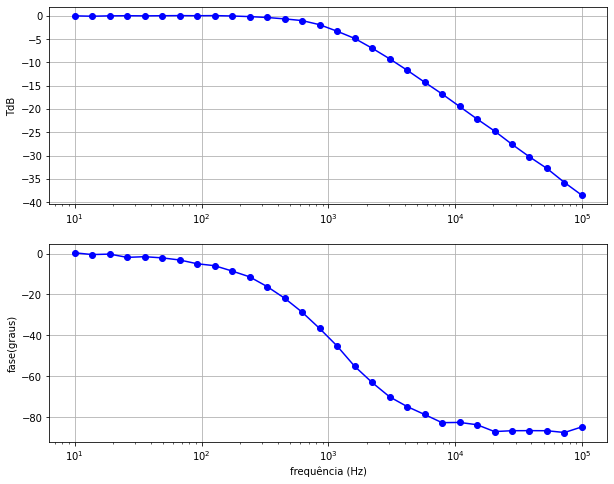

In [54]:
## Análise de dados (não mude a variável PATH)
T = Vpp2/Vpp1   # cálculo da transmissão 
T_dB = 20*np.log10(T)  # transmissão em dB
dados = pd.DataFrame()   # inicializa um dataframe do pandas
dados['frequencia (Hz)']= freq
dados['Vpp1 (V)'], dados['Vpp2 (V)'] = Vpp1, Vpp2
dados['fase (rad)'] = -phase1

# plota o diagrama de bode para a transmissão e exporta em png
fig,ax = plt.subplots(2,1,figsize=(10,8))   # define uma figura
ax0=ax[0]
ax0.plot(freq,T_dB, 'bo-')   # plota a transmissão  
ax0.set_xscale('log')   # seta a escala de x para logaritmica
ax0.grid()
ax0.set_ylabel('TdB')   # seta escala do eixo y
#segundo eixo
ax0=ax[1]
ax0.plot(freq,-phase1, 'bo-')   # plota a transmissão  
ax0.set_xscale('log')   # seta a escala de x para logaritmica
# Por que não usamos escala log no eixo y também?
ax0.set_xlabel('frequência (Hz)')   # seta escala do eixo x

ax0.set_ylabel('fase(graus)')   # seta escala do eixo y
ax0.grid()
fig.savefig(PATH + 'bode_diag.pdf', bbox_inches = 'tight')  # salva figura na pasta de trabalho
dados.to_csv(PATH + 'dados_sweep.csv')
plt.show()

/Users/gsw/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: MaxNLocator.set_params got an unexpected parameter: nticks
  


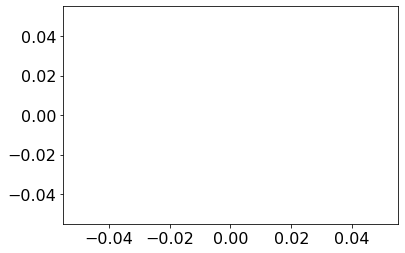

In [65]:
#Ajsutando fontes padrão dos gráficos
font = { 'weight' : 'normal',
        'size'   : 16}

plt.rc('font', **font)
#Ajsutando espessura das linhas padrão dos gráficos
plt.rcParams['lines.linewidth'] = 2;
plt.locator_params(nticks=4)

/usr/local/lib/python3.7/site-packages/pyvisa/resources/messagebased.py:634: FutureWarning: query_values is deprecated and will be removed in 1.10, use query_ascii_values or quey_binary_values instead.
  'instead.', FutureWarning)
/usr/local/lib/python3.7/site-packages/pyvisa/resources/messagebased.py:107: FutureWarning: values_format is deprecated and will be removed in 1.10
  '1.10', FutureWarning)
/usr/local/lib/python3.7/site-packages/pyvisa/resources/messagebased.py:634: FutureWarning: query_values is deprecated and will be removed in 1.10, use query_ascii_values or quey_binary_values instead.
  'instead.', FutureWarning)
/usr/local/lib/python3.7/site-packages/pyvisa/resources/messagebased.py:107: FutureWarning: values_format is deprecated and will be removed in 1.10
  '1.10', FutureWarning)


... file => exemplo-pylef/passa-altas/traços-temporal-imagens/2021_03_31/freq_sweep1_16_29_08 saved !!


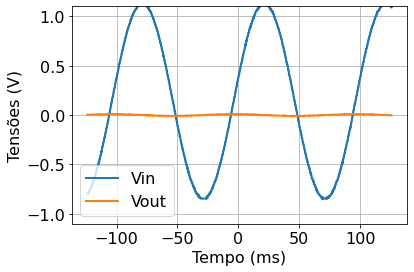

/usr/local/lib/python3.7/site-packages/pyvisa/resources/messagebased.py:634: FutureWarning: query_values is deprecated and will be removed in 1.10, use query_ascii_values or quey_binary_values instead.
  'instead.', FutureWarning)
/usr/local/lib/python3.7/site-packages/pyvisa/resources/messagebased.py:107: FutureWarning: values_format is deprecated and will be removed in 1.10
  '1.10', FutureWarning)


... file => exemplo-pylef/passa-altas/traços-temporal-imagens/2021_03_31/freq_sweep2_16_29_21 saved !!


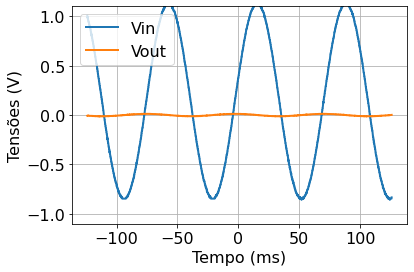

KeyboardInterrupt: 

In [70]:
#### Aquisição de dados!! ####
freq = np.logspace(np.log10(freq0), np.log10(freq1), Nfreq, endpoint = True)  # varredura logaritmica
Vpp1, Vpp2 = [], []    # listas para guardar as variáveis
phase1, phase2 = [], []    # listas para guardar as variáveis
### aquisição de dados no gerador com varredura de frequência
for m, freqP in enumerate(list(freq)):  # loop de aquisição
    ### ajuste dos instrumentos
    func_gen.ch1.set_frequency(freqP)   # muda a frequência
    periodP = 1./freqP   # período da onda
    num = np.floor(-np.log10(periodP)/3.) + 1 # referência para a escala do gráfico
    scope.set_horizontal_scale(periodP/4.)  # escala horizontal = 1/4 período (2.5 oscilações em tela)
    time.sleep(0.05)   # espere 50 microssegundos
    scope.ch2.set_smart_scale()    #  rescala o canal 2
    ### aquisição de dados
    Vpp1.append(scope.ch1.measure.Vpp()) # acumula a medida do Vpp no canal 1
    phase1.append(scope.ch1.measure.phase()) # acumula a medida da fase no canal 1    
    time.sleep(0.05)  # wait between the data acquisition
    Vpp2.append(scope.ch2.measure.Vpp())  # acumula a medida do Vpp no canal 2
    phase2.append(scope.ch2.measure.phase()) # acumula a medida da fase no canal 2
    ### leitura dos traços temporais
    (t1, V1) = scope.ch1.read_channel()  # mede o canal 1
    (t2, V2) = scope.ch2.read_channel()  # mede o canal 2
    ### produção das figuras
    fig = plt.figure()  # definição da figura
    ax = fig.add_subplot(111)  # definição do eixo
    ax.plot(t1*10**(3*num), V1, label = 'Vin')   # plota canal 1
    ax.plot(t2*10**(3*num), V2, label = 'Vout')   # plota canal 2
    plt.axis([None, None, -1.1*Vpp/2, 1.1*Vpp/2])    # ajusta os máximos e mínimos dos gráficos
    plt.grid()
    ax.set_ylabel('Tensões (V)')
    ax.legend()   # imprime as legendas no gráfico
    if num == 0.0: ax.set_xlabel('Tempo (s)')    
    if num == 1.0: ax.set_xlabel('Tempo (ms)')
    if num == 2.0: ax.set_xlabel('Tempo (us)')
    ### salva em arquivo os dados da aquisição
    file_sweep_name = 'freq_sweep' + str(m + 1)   # nome dos arquivos de sweep
    scope.save_channels(file_sweep_name, PATH = PATH + 'traços-temporal-imagens')    
    fig.savefig(PATH + 'traços-temporal-imagens/' + file_sweep_name + '.png', bbox_inches = 'tight')
    plt.show()      # impressão na tela!
Vpp1 = np.array(Vpp1)  # convete a lista em array
Vpp2 = np.array(Vpp2)  # convete a lista em array
phase1 = np.array(phase1)  # convete a lista em array
phase2 = np.array(phase2)  # convete a lista em arra

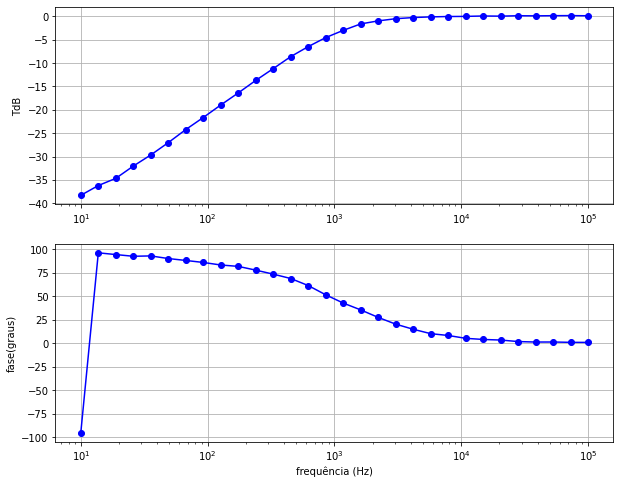

In [50]:
## Análise de dados (não mude a variável PATH)
T = Vpp2/Vpp1   # cálculo da transmissão 
T_dB = 20*np.log10(T)  # transmissão em dB
dados = pd.DataFrame()   # inicializa um dataframe do pandas
dados['frequencia (Hz)']= freq
dados['Vpp1 (V)'], dados['Vpp2 (V)'] = Vpp1, Vpp2
dados['fase (rad)'] = -phase1

# plota o diagrama de bode para a transmissão e exporta em png
fig,ax = plt.subplots(2,1,figsize=(10,8))   # define uma figura
ax0=ax[0]
ax0.plot(freq,T_dB, 'bo-')   # plota a transmissão  
ax0.set_xscale('log')   # seta a escala de x para logaritmica
ax0.grid()
ax0.set_ylabel('TdB')   # seta escala do eixo y
#segundo eixo
ax0=ax[1]
ax0.plot(freq,-phase1, 'bo-')   # plota a transmissão  
ax0.set_xscale('log')   # seta a escala de x para logaritmica
# Por que não usamos escala log no eixo y também?
ax0.set_xlabel('frequência (Hz)')   # seta escala do eixo x

ax0.set_ylabel('fase(graus)')   # seta escala do eixo y
ax0.grid()
fig.savefig(PATH + 'bode_diag.pdf', bbox_inches = 'tight')  # salva figura na pasta de trabalho
dados.to_csv(PATH + 'dados_sweep.csv')
plt.show()

### Plots

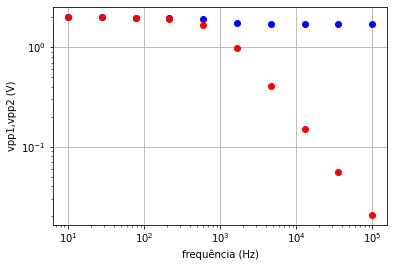

In [47]:
fig = plt.figure()   # define uma figura
ax = fig.add_subplot(111)  # define um eixo
ax.plot(freq,Vpp1, 'bo')   # plota a transmissão  
ax.plot(freq,Vpp2, 'ro')   # plota a transmissão  
ax.set_xscale('log')   # seta a escala de x para logaritmica
ax.set_yscale('log')   # seta a escala de x para logaritmica
# Por que não usamos escala log no eixo y também?
ax.set_xlabel('frequência (Hz)')   # seta escala do eixo x
ax.set_ylabel('vpp1,vpp2 (V)')   # seta escala do eixo y
plt.grid()

In [48]:
## Análise de dados (não mude a variável PATH)
T = (Vpp2/Vpp1)**2   # cálculo da transmissão 
T_dB = 10*np.log10(T)  # transmissão em dB

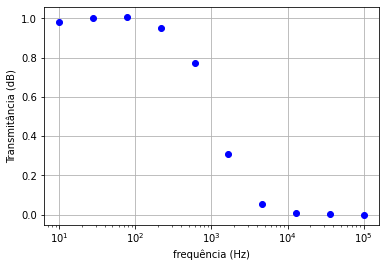

In [50]:
fig = plt.figure()   # define uma figura
ax = fig.add_subplot(111)  # define um eixo
ax.plot(freq,T, 'bo')   # plota a transmissão  
ax.set_xscale('log')   # seta a escala de x para logaritmica
# Por que não usamos escala log no eixo y também?
ax.set_xlabel('frequência (Hz)')   # seta escala do eixo x
ax.set_ylabel('Transmitância (dB)')   # seta escala do eixo y
plt.grid()

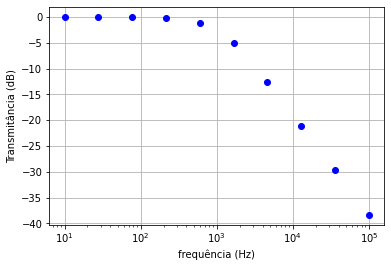

In [49]:
fig = plt.figure()   # define uma figura
ax = fig.add_subplot(111)  # define um eixo
ax.plot(freq,T_dB, 'bo')   # plota a transmissão  
ax.set_xscale('log')   # seta a escala de x para logaritmica
# Por que não usamos escala log no eixo y também?
ax.set_xlabel('frequência (Hz)')   # seta escala do eixo x
ax.set_ylabel('Transmitância (dB)')   # seta escala do eixo y
plt.grid()

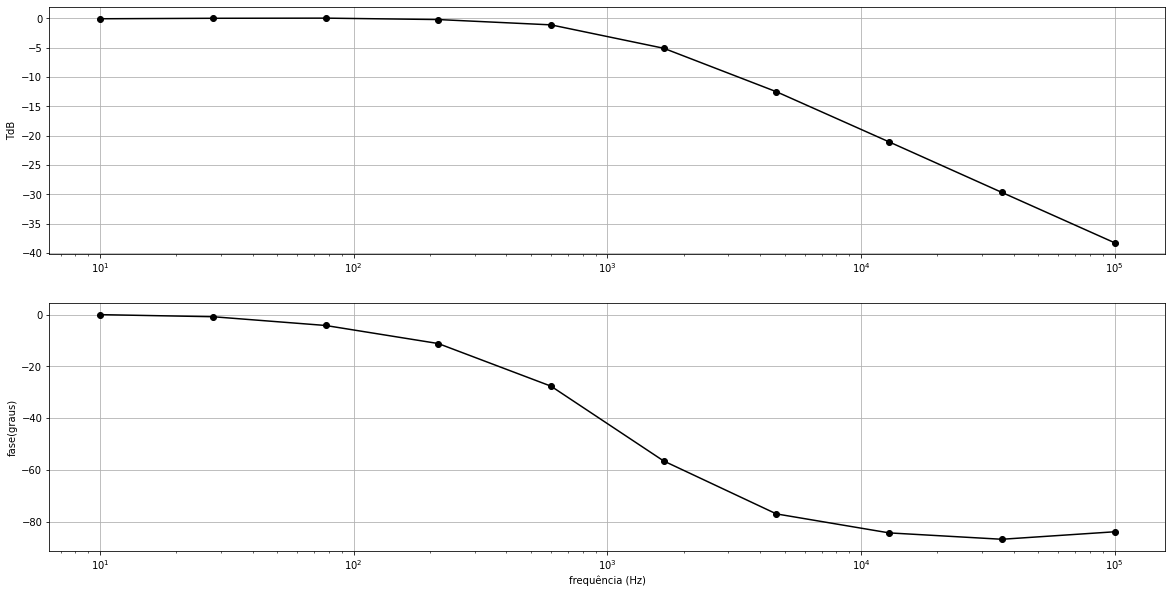

In [61]:
fig,ax = plt.subplots(2,1,figsize=(20,10))   # define uma figura
ax0=ax[0]
ax0.plot(freq,T_dB, 'ko-')   # plota a transmissão  
ax0.set_xscale('log')   # seta a escala de x para logaritmica
ax0.grid()
ax0.set_ylabel('TdB')   # seta escala do eixo y
#segundo eixo
ax0=ax[1]
ax0.plot(freq,-phase1, 'ko-')   # plota a transmissão  
ax0.set_xscale('log')   # seta a escala de x para logaritmica
# Por que não usamos escala log no eixo y também?
ax0.set_xlabel('frequência (Hz)')   # seta escala do eixo x

ax0.set_ylabel('fase(graus)')   # seta escala do eixo y
ax0.grid()

In [ ]:
dados = pd.DataFrame()   # inicializa um dataframe do pandas
dados['Vpp1 (V)'], dados['Vpp2 (V)'] = Vpp1, Vpp2
dados['fase (rad)'] = -phase1
dados['frequencia (Hz)']
# plota o diagrama de bode para a transmissão e exporta em png

fig.savefig(PATH + 'bode_diag.png', bbox_inches = 'tight')  # salva figura na pasta de trabalho
dados.to_csv(PATH + 'dados_sweep.csv')
plt.show()

## Varredura salvando traços temporais

In [9]:
#### Aquisição de dados!! ####
freq = np.logspace(np.log10(freq0), np.log10(freq1), Nfreq, endpoint = True)  # varredura logaritmica
Vpp1, Vpp2 = [], []    # listas para guardar as variáveis
phase1, phase2 = [], []    # listas para guardar as variáveis
### aquisição de dados no gerador com varredura de frequência
for m, freqP in enumerate(list(freq)):  # loop de aquisição
    ### ajuste dos instrumentos
    func_gen.ch1.set_frequency(freqP)   # muda a frequência
    periodP = 1./freqP   # período da onda
    num = np.floor(-np.log10(periodP)/3.) + 1 # referência para a escala do gráfico
    scope.set_horizontal_scale(periodP/4.)  # escala horizontal = 1/4 período (2.5 oscilações em tela)
    time.sleep(0.05)   # espere 50 microssegundos
    scope.ch2.set_smart_scale()    #  rescala o canal 2
    ### aquisição de dados
    Vpp1.append(scope.ch1.measure.Vpp()) # acumula a medida do Vpp no canal 1
    phase1.append(scope.ch1.measure.phase()) # acumula a medida da fase no canal 1    
    time.sleep(0.05)  # wait between the data acquisition
    Vpp2.append(scope.ch2.measure.Vpp())  # acumula a medida do Vpp no canal 2
    phase2.append(scope.ch2.measure.phase()) # acumula a medida da fase no canal 2
    ### salva em arquivo os dados da aquisição
    file_sweep_name = 'freq_sweep' + str(m + 1)   # nome dos arquivos de sweep
    scope.save_channels(file_sweep_name, PATH = PATH)    
    plt.show()      # impressão na tela!
Vpp1 = np.array(Vpp1)  # convete a lista em array
Vpp2 = np.array(Vpp2)  # convete a lista em array
phase1 = np.array(phase1)  # convete a lista em array
phase2 = np.array(phase2)  # convete a lista em arra

/usr/local/lib/python3.7/site-packages/pyvisa/resources/messagebased.py:634: FutureWarning: query_values is deprecated and will be removed in 1.10, use query_ascii_values or quey_binary_values instead.
  'instead.', FutureWarning)


... file => exemplo-pylef/2021_03_31/freq_sweep1_13_54_50 saved !!
... file => exemplo-pylef/2021_03_31/freq_sweep2_13_55_01 saved !!
... file => exemplo-pylef/2021_03_31/freq_sweep3_13_55_13 saved !!
... file => exemplo-pylef/2021_03_31/freq_sweep4_13_55_25 saved !!
... file => exemplo-pylef/2021_03_31/freq_sweep5_13_55_37 saved !!
... file => exemplo-pylef/2021_03_31/freq_sweep6_13_55_49 saved !!
... file => exemplo-pylef/2021_03_31/freq_sweep7_13_56_01 saved !!
... file => exemplo-pylef/2021_03_31/freq_sweep8_13_56_13 saved !!
... file => exemplo-pylef/2021_03_31/freq_sweep9_13_56_25 saved !!
... file => exemplo-pylef/2021_03_31/freq_sweep10_13_56_36 saved !!
